# Spatial Filtering

In [2]:
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline

## Section 1: Basic Map Algebra
#### How the footprint works

In [9]:
c = np.random.randint(0, 10, 9)
indata_ = np.reshape(c, (3,3))
# write a null in the middle
window = np.where(indata_==3, np.nan, indata_) 
window

array([[ 1.,  7.,  9.],
       [ 4., nan,  5.],
       [ 7.,  7.,  0.]])

Replace ```nan```(null) values with the mean from the array

In [10]:
# The middle value is calculated based on 
# its surrounding neighbors in the input dataset 
np.where(np.isnan(window),
         np.nanmean(window),window)

array([[1., 7., 9.],
       [4., 5., 5.],
       [7., 7., 0.]])

In [12]:
(1+7+9+4+5+7+7)/8 # the math checks out

5.0

## Apply footprint filtering to a slightly bigger matrix

In [19]:
# generate random matrix 
a = np.random.randint(0, 10, 64)
indata01 = np.reshape(a, (8,8))
data = np.where(indata01==0, np.nan, indata01) # replace all zero values with nan
data

array([[ 6.,  9.,  4.,  4.,  4., nan, nan,  7.],
       [ 1.,  5.,  5.,  7.,  6.,  9.,  6.,  4.],
       [ 2.,  2.,  1.,  6.,  7.,  3., nan,  8.],
       [nan,  6.,  9.,  8.,  2.,  6.,  3.,  4.],
       [ 1.,  8.,  3.,  3.,  5.,  7., nan,  3.],
       [ 1.,  8.,  6.,  2.,  4.,  7.,  9.,  6.],
       [ 1., nan,  6.,  1.,  1.,  2.,  8.,  7.],
       [ 6.,  5.,  8.,  3.,  7.,  7.,  8.,  3.]])

In [20]:
def conv_mapping(x):
    """
    When the forth value of the filter array (the center of the window) 
    is null, replace it with the mean of the surrounding values.
    """
    if np.isnan(x[4]) and not np.isnan(np.delete(x, 4)).all():
        return np.nanmean(np.delete(x, 4))
    else:
        return x[4]

In [21]:
mask = np.ones((3, 3))
result = ndimage.generic_filter(data, function=conv_mapping, footprint=mask, mode='constant', cval=np.NaN)
np.set_printoptions(precision=3)
print(result)

[[6.    9.    4.    4.    4.    6.25  6.5   7.   ]
 [1.    5.    5.    7.    6.    9.    6.    4.   ]
 [2.    2.    1.    6.    7.    3.    5.375 8.   ]
 [3.8   6.    9.    8.    2.    6.    3.    4.   ]
 [1.    8.    3.    3.    5.    7.    5.625 3.   ]
 [1.    8.    6.    2.    4.    7.    9.    6.   ]
 [1.    5.125 6.    1.    1.    2.    8.    7.   ]
 [6.    5.    8.    3.    7.    7.    8.    3.   ]]


In [22]:
(1+8+6+1+6+6+5+8)/8 # the math checks out!

5.125

## Apply filter to a "real-world" raster data matrix
Using this technique we can apply our "filter footprint" to a "raster" matrix to eliminate ```nan``` values.

### upload dataset 

In [29]:
df = pd.read_csv("data/data.csv")
df.shape, df.isna().sum() # how many nulls per column?

((220739, 4),
 Unnamed: 0      0
 x               0
 y               0
 elevation     100
 dtype: int64)

## Transform data: from stacked to matrix (grid) form

In [32]:
def make_grid(df,resolution):
    """
    x_values - numpy array
    y_values - numpy array
    resolution - integer (1 is slow, 50 is fast)
    points - numpy array
    values - numpy array
    """
    # Define interpolation inputs and
    # convert everything to NumPy arrays for optimization
    points = np.array(list(zip(df.x,df.y)))
    values = np.array(df.elevation.values)
    x_values = np.array(df.x)
    y_values = np.array(df.y)
    xRange = np.arange(x_values.min(),x_values.max() + resolution, resolution)
    yRange = np.arange(y_values.min(),y_values.max() + resolution, resolution)
    gridX,gridY = np.meshgrid(xRange, yRange)
    gridPh = griddata(points, values, (gridX,gridY), method='nearest')
    return gridPh

In [34]:
grid = make_grid(df, 8)

Text(0.5, 1.0, 'Elevation')

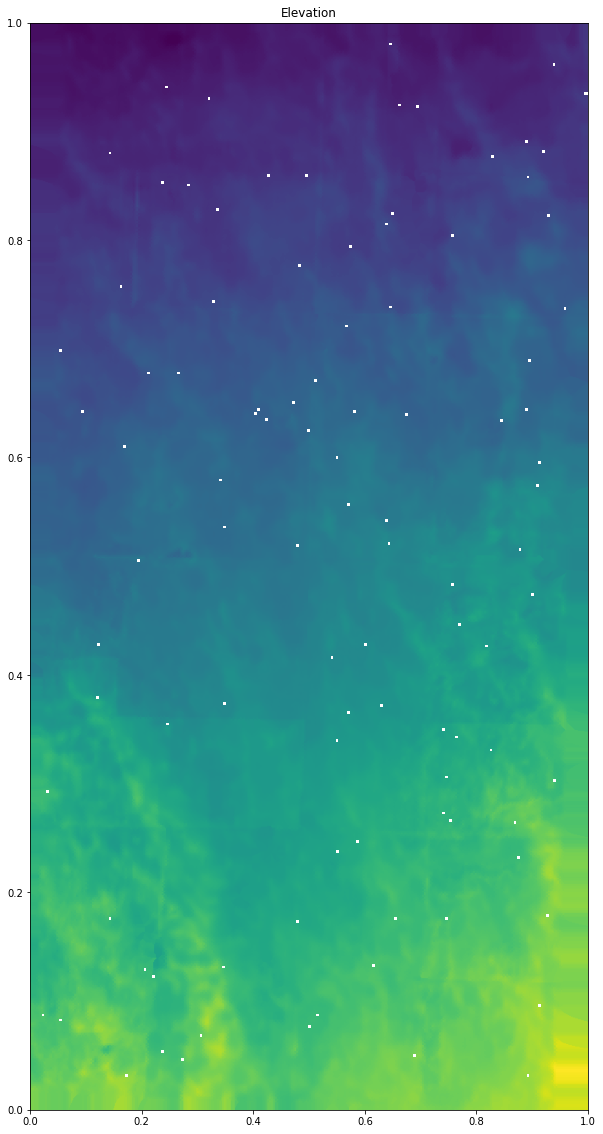

In [44]:
# BEFORE
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(grid.T, extent=(0,1,0,1), origin='lower',aspect='auto')
plt.title('Elevation')

As we can see, missing pixels can be found. The task is to smooth them away.

In [36]:
print("This many null values: ", len(np.argwhere(np.isnan(grid))))

This many null values:  368


In [37]:
np.argwhere(np.isnan(grid))[:5]

array([[ 15, 110],
       [ 15, 111],
       [ 20, 371],
       [ 20, 372],
       [ 21, 371]])

In [38]:
grid[15,110] # Let's see if this one changes after filtering

nan

## Apply spatial filtering to eliminate null values 

In [39]:
def filterize(grid, function, footprint):
    grid_smooth = ndimage.generic_filter(grid,
                   function=function,
                   footprint=footprint, mode='constant', cval=np.NaN)
    return grid_smooth

In [41]:
grid_smooth = filterize(grid, conv_mapping, np.ones((3, 3)))
len(np.argwhere(np.isnan(grid_smooth))) # how many null values now

0

In [111]:
print("This many null values: ", len(np.argwhere(np.isnan(grid_smooth))))

This many null values:  17004


In [42]:
grid_smooth[15,110]

261.78285714285715

Text(0.5, 1.0, 'Elevation')

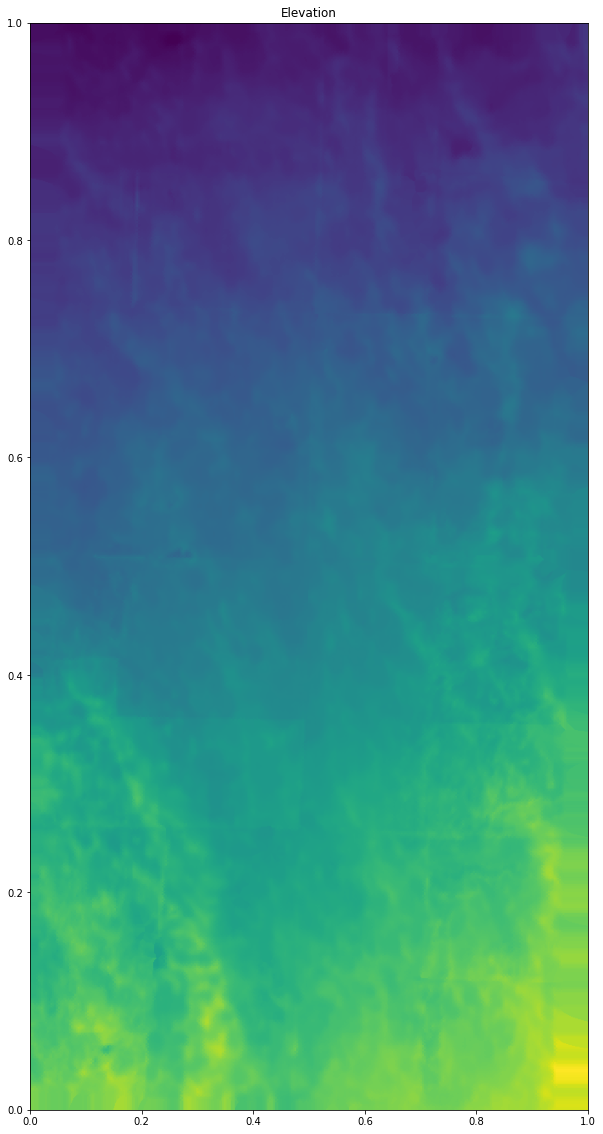

In [45]:
# AFTER
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(grid_smooth.T, extent=(0,1,0,1), origin='lower',aspect='auto')
plt.title('Elevation')

No null values to be seen.